# 1. Introduction

This pipleline tries to create a model for bank marketing dataset that is available through UCI. The model is supposed to rank order the population according to the score it produces, so that we can target the most likely candidates, and save on marketing dollars. The score can be thought of as the probability of opening accounts for example.

Since this model is trying to rank order the population, we care more about precision (catching true positive out of fixed number of positive outcomes), and metrics that work with it like F1 score.

There is explanation of the variables in the source, [here](https://archive.ics.uci.edu/dataset/222/bank+marketing), so we won't get into that for brevity. But it is worth noting that variable "duration" is not helpful as it is the length of last phone conversation with the agent. Since we use model before this call, we can't use it for prediction.

Also it is worth noting that variable "campaign" is not used in this notebook because it captures the number of calls in this campaign, which of course is not available beforehand.




The structure of the notebook is as follows:

    1[Introduction] --> 2[Data Loading]
    2 --> 3[Exploratory Data Analysis (EDA)]
    3 --> 4[Feature Engineering]
    4 --> 5[Preprocessing with ColumnTransformer]
    5 --> 6[Modeling]
    6 --> 6.1[Logistic Regression]
    6 --> 6.2[Random Forest]
    6 --> 6.3[XGBoost]
    6 --> 6.4[Voting Classifier]
    6 --> 7[Evaluation]
    7 --> 8[Metrics: F1, ROC AUC, Avg Precision, Top-K Precision]
    9 --> 10[ROC Curve & Feature Importance Visualization]
    10 --> 11[Business Insights & Conclusions]

# 2. Loading the Dataset and Basic Info

In [5]:
!pip install -q ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets


In [6]:
# Display the shape of the feature dataframe (X)
print("Shape of features (X):", X.shape)

# Display the shape of the target dataframe (y)
print("Shape of targets (y):", y.shape)

Shape of features (X): (45211, 16)
Shape of targets (y): (45211, 1)


In [7]:
# Display basic information about the feature dataframe (X)
print("\nInfo about features (X):")
X.info()


Info about features (X):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


In [8]:
# Display basic information about the target dataframe (y)
print("\nInfo about targets (y):")
y.info()


Info about targets (y):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       45211 non-null  object
dtypes: object(1)
memory usage: 353.3+ KB


# 3. Exploratory Data Analysis (EDA)

Before going into EDA, it is worth noting that variable "duration" is not helpful as per variable description of the data. The duration is the duration of the last call that either resulted or didn't result in opening account, so it is not known beforehand, and we should discard it for building a realistic model. This variable is highly predictive of the outcome, but since we are not going to use it we drop it even before the EDA.


The same is true for variable "campaign" and we should drop that too before building the model. Value of variable "campaign" is not known before running our model to rank order the population and targeting the people. A different model can be built to include variable "campaign - 1" for when we have targeted an individual in current campaign and we want to rank order the people in this campaign based on effectiveness of the next phone call. But we won't do that here and we'll leave it as future steps.

### Summary Statistics, Missing Values, and Class Distribution

In [9]:
# Display summary statistics for numerical features
display(X.describe())

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**Findings**

pday has a lot of rows equal to -1. This means they were not contacted before. So we have to create a new categorical feature down the road, to capture this.

In [10]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


In [11]:
# Display summary statistics for categorical features
display(X.describe(include='object'))

,job,marital,education,default,housing,loan,contact,month,poutcome
count,44923,45211,43354,45211,45211,45211,32191,45211,8252
unique,11,3,3,2,2,2,2,12,3
top,blue-collar,married,secondary,no,yes,no,cellular,may,failure
freq,9732,27214,23202,44396,25130,37967,29285,13766,4901


In [12]:
# List of categorical columns
categorical_cols_to_check = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Display unique values for each column
for col in categorical_cols_to_check:
    if col in X.columns:
        print(f"Unique values in '{col}':")
        display(X[col].unique())
    else:
        print(f"Column '{col}' not found in the DataFrame.")

Unique values in 'job':


array(['management', 'technician', 'entrepreneur', 'blue-collar', nan,
       'retired', 'admin.', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

Unique values in 'marital':


array(['married', 'single', 'divorced'], dtype=object)

Unique values in 'education':


array(['tertiary', 'secondary', nan, 'primary'], dtype=object)

Unique values in 'default':


array(['no', 'yes'], dtype=object)

Unique values in 'housing':


array(['yes', 'no'], dtype=object)

Unique values in 'loan':


array(['no', 'yes'], dtype=object)

Unique values in 'contact':


array([nan, 'cellular', 'telephone'], dtype=object)

Unique values in 'month':


array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

Unique values in 'poutcome':


array([nan, 'failure', 'other', 'success'], dtype=object)

**Findings:**

There are no "weird" values in the categorical features. Whatever nan, we shall give to missing or unknown category.

In [13]:
# Check for missing values
print("\nMissing values in features (X):")
print(X.isnull().sum())


Missing values in features (X):
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64


In [14]:
# Check for missing values in the target variable
print("\nMissing values in target (y):")
print(y.isnull().sum())


Missing values in target (y):
y    0
dtype: int64


In [15]:
# Display the distribution of the target variable
print("\nDistribution of target variable (y):")
display(y['y'].value_counts()/len(y))


Distribution of target variable (y):


,count
y,
no,0.883015
yes,0.116985


**Findings:**

This tells us that we have an imbalanced data, so we need to use average precision or F1 score for evaluation, and also, we may need to do oversampling or undersampling to enhance the model.

### Univariate and Bivariate Visualizations

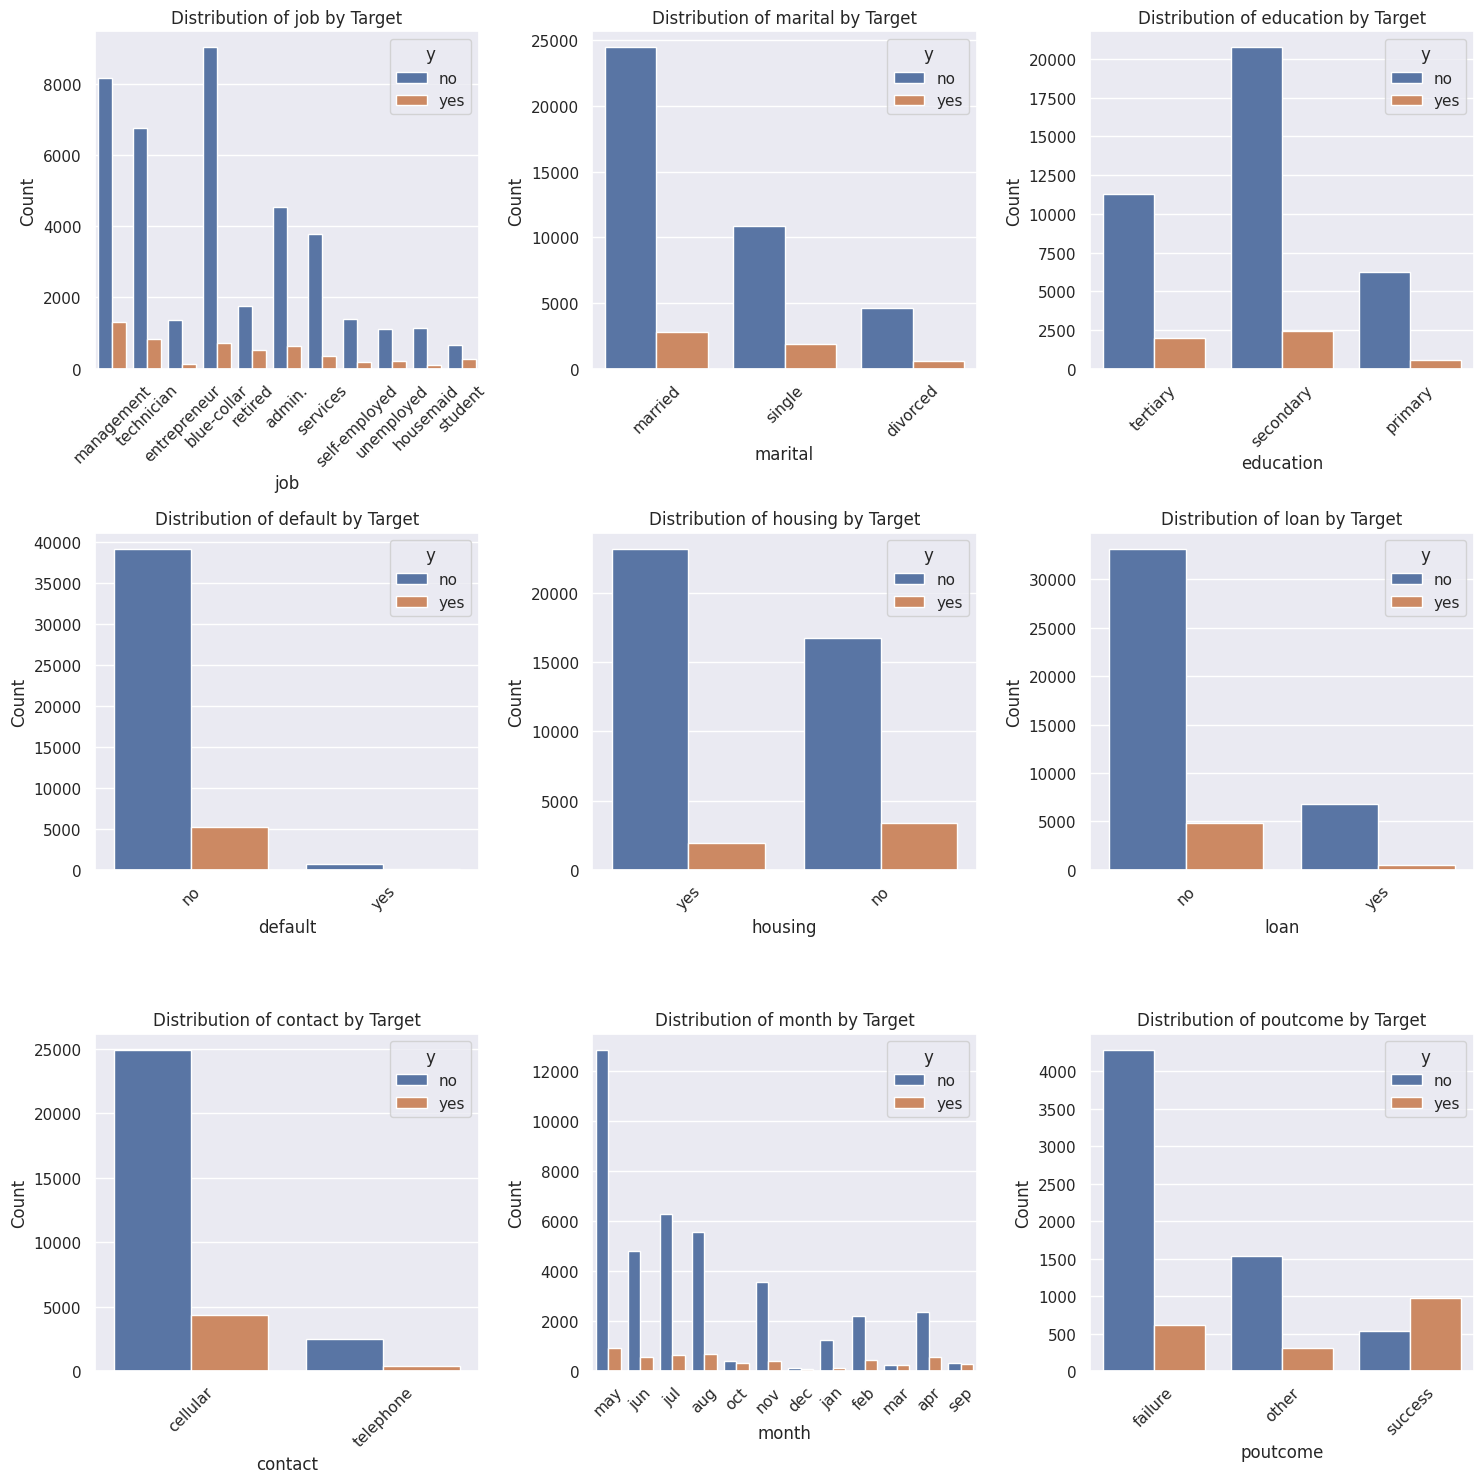

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Select categorical columns for visualization
categorical_cols = X.select_dtypes(include=['object']).columns

# Determine the number of rows and columns for the grid
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create bar charts for categorical features with target variable in a grid
for i, col in enumerate(categorical_cols):
    sns.countplot(data=X, x=col, hue=y['y'], ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Target')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Findings:**

1.  Some categories within features like job, marital, education, contact, and poutcome show varying subscription rates, as seen in the bar charts. For example, 'retired' and 'student' seem to have higher subscription rates compared to other job types.

2.  The 'success' outcome in poutcome is strongly associated with a 'yes' subscription.

3.  The 'unknown' category in 'contact' and 'poutcome' (due to missing values)
is also a significant group.

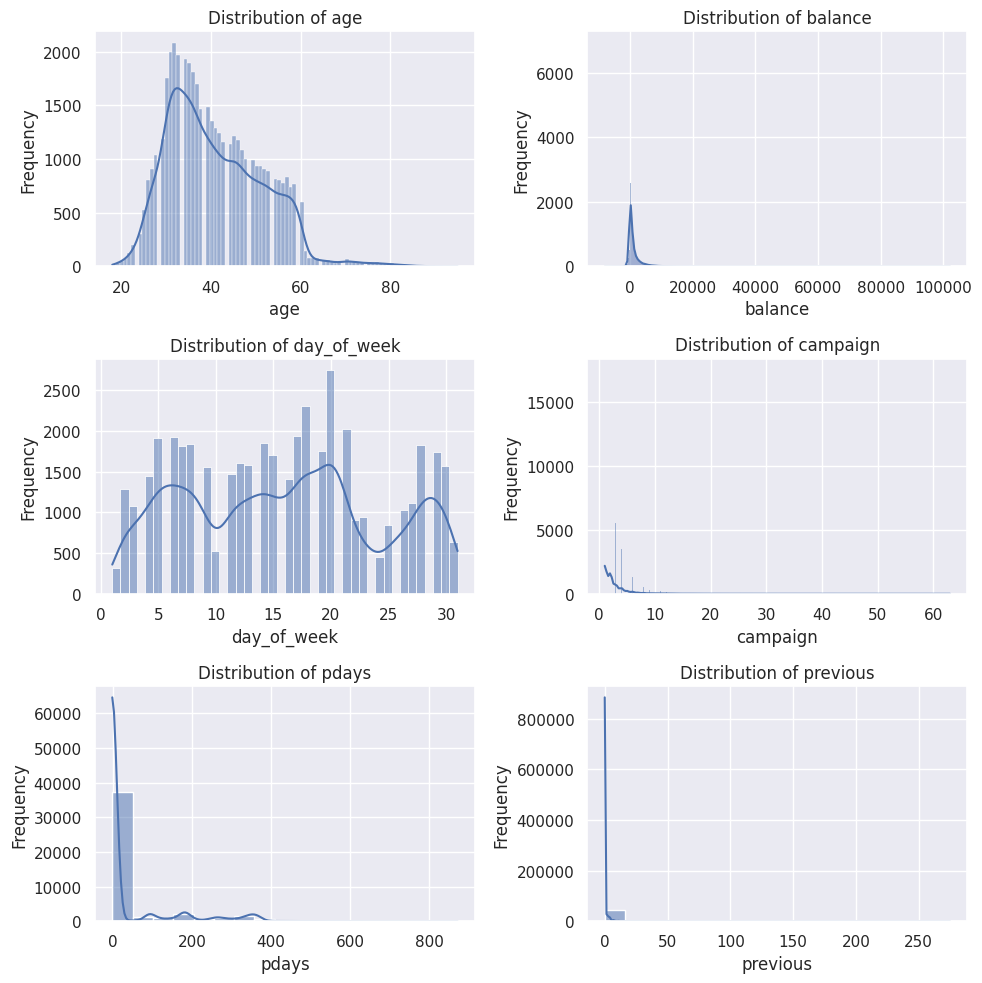

In [17]:
# Select numerical columns for visualization
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('duration')


# Determine the number of rows and columns for the grid
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create histograms for numerical features in a grid
for i, col in enumerate(numerical_cols):
    sns.histplot(data=X, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Findings:**

1. There is some skewness to the right in most of these variables and we may need to do some transformation on them.

2. Day of the week ranges from 1 to 31, which suggests it is day of the month, not day of the week. We can change it's name to day_of_month.

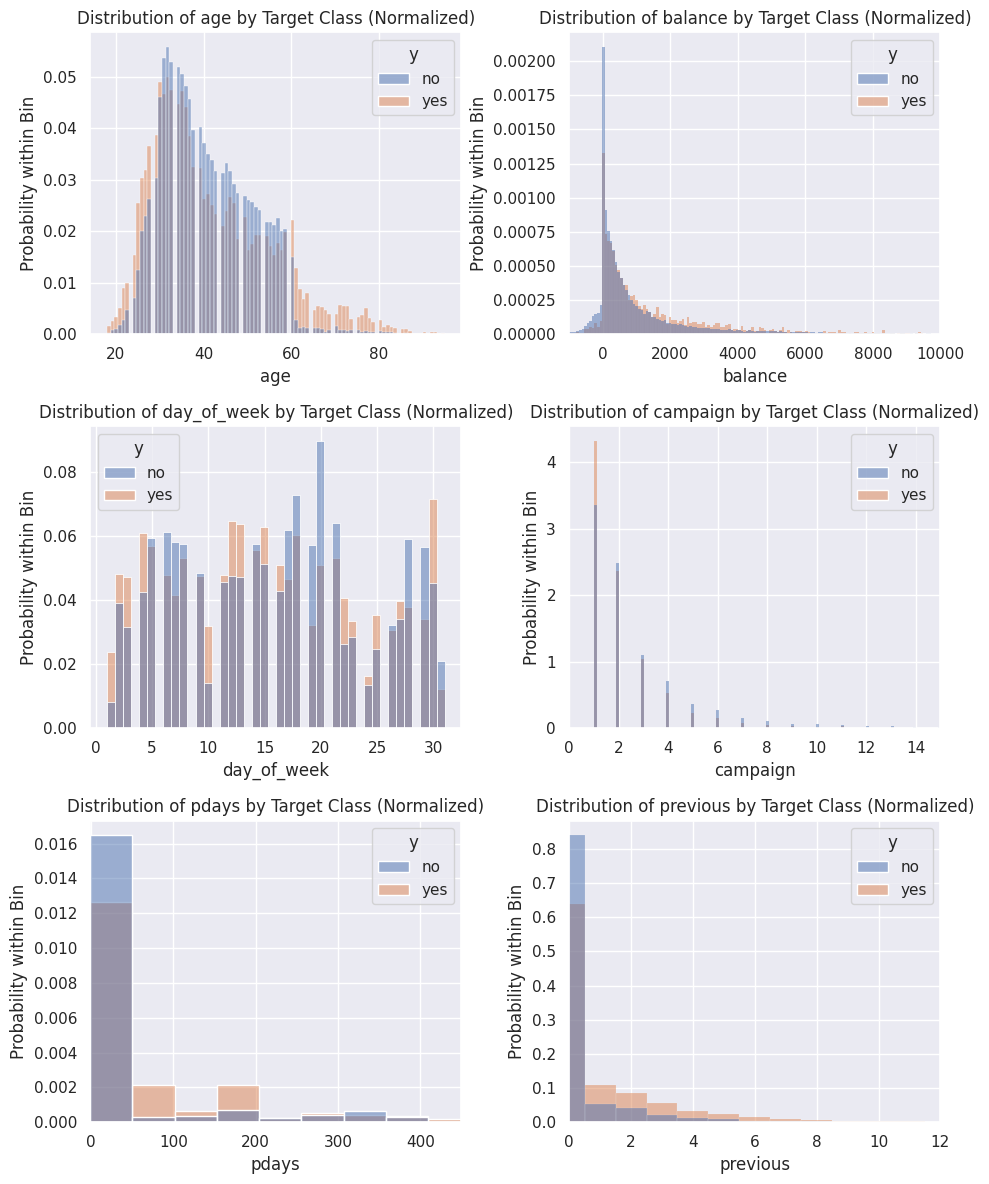

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define x-axis limits for specific columns
x_limits = {
    'balance': (-1000, 10000),
    # 'duration': (0, 2000),
    'campaign': (0, 15),
    'pdays': (-1, 450),
    'previous': (0, 12)
}

# Determine the number of rows and columns for the grid
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create normalized histograms for numerical features by target class in a grid
for i, col in enumerate(numerical_cols):
    if col == 'previous':
      sns.histplot(data=X.join(y), x=col, hue='y', kde=False, stat='density',
             common_norm=False, discrete=True)
    else:
      sns.histplot(data=X.join(y), x=col, hue='y', kde=False, stat='density',
                 common_norm=False, ax=axes[i])

    axes[i].set_title(f'Distribution of {col} by Target Class (Normalized)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Probability within Bin')

    # Set x-axis limits if defined for the column
    if col in x_limits:
        axes[i].set_xlim(x_limits[col])

plt.tight_layout()
plt.show()

### Correlation Matrix and Scatterplots

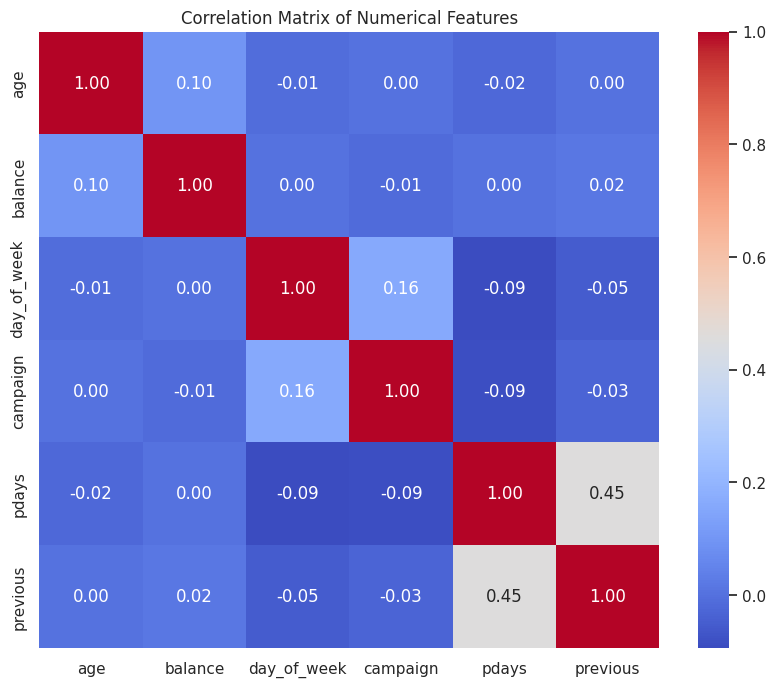

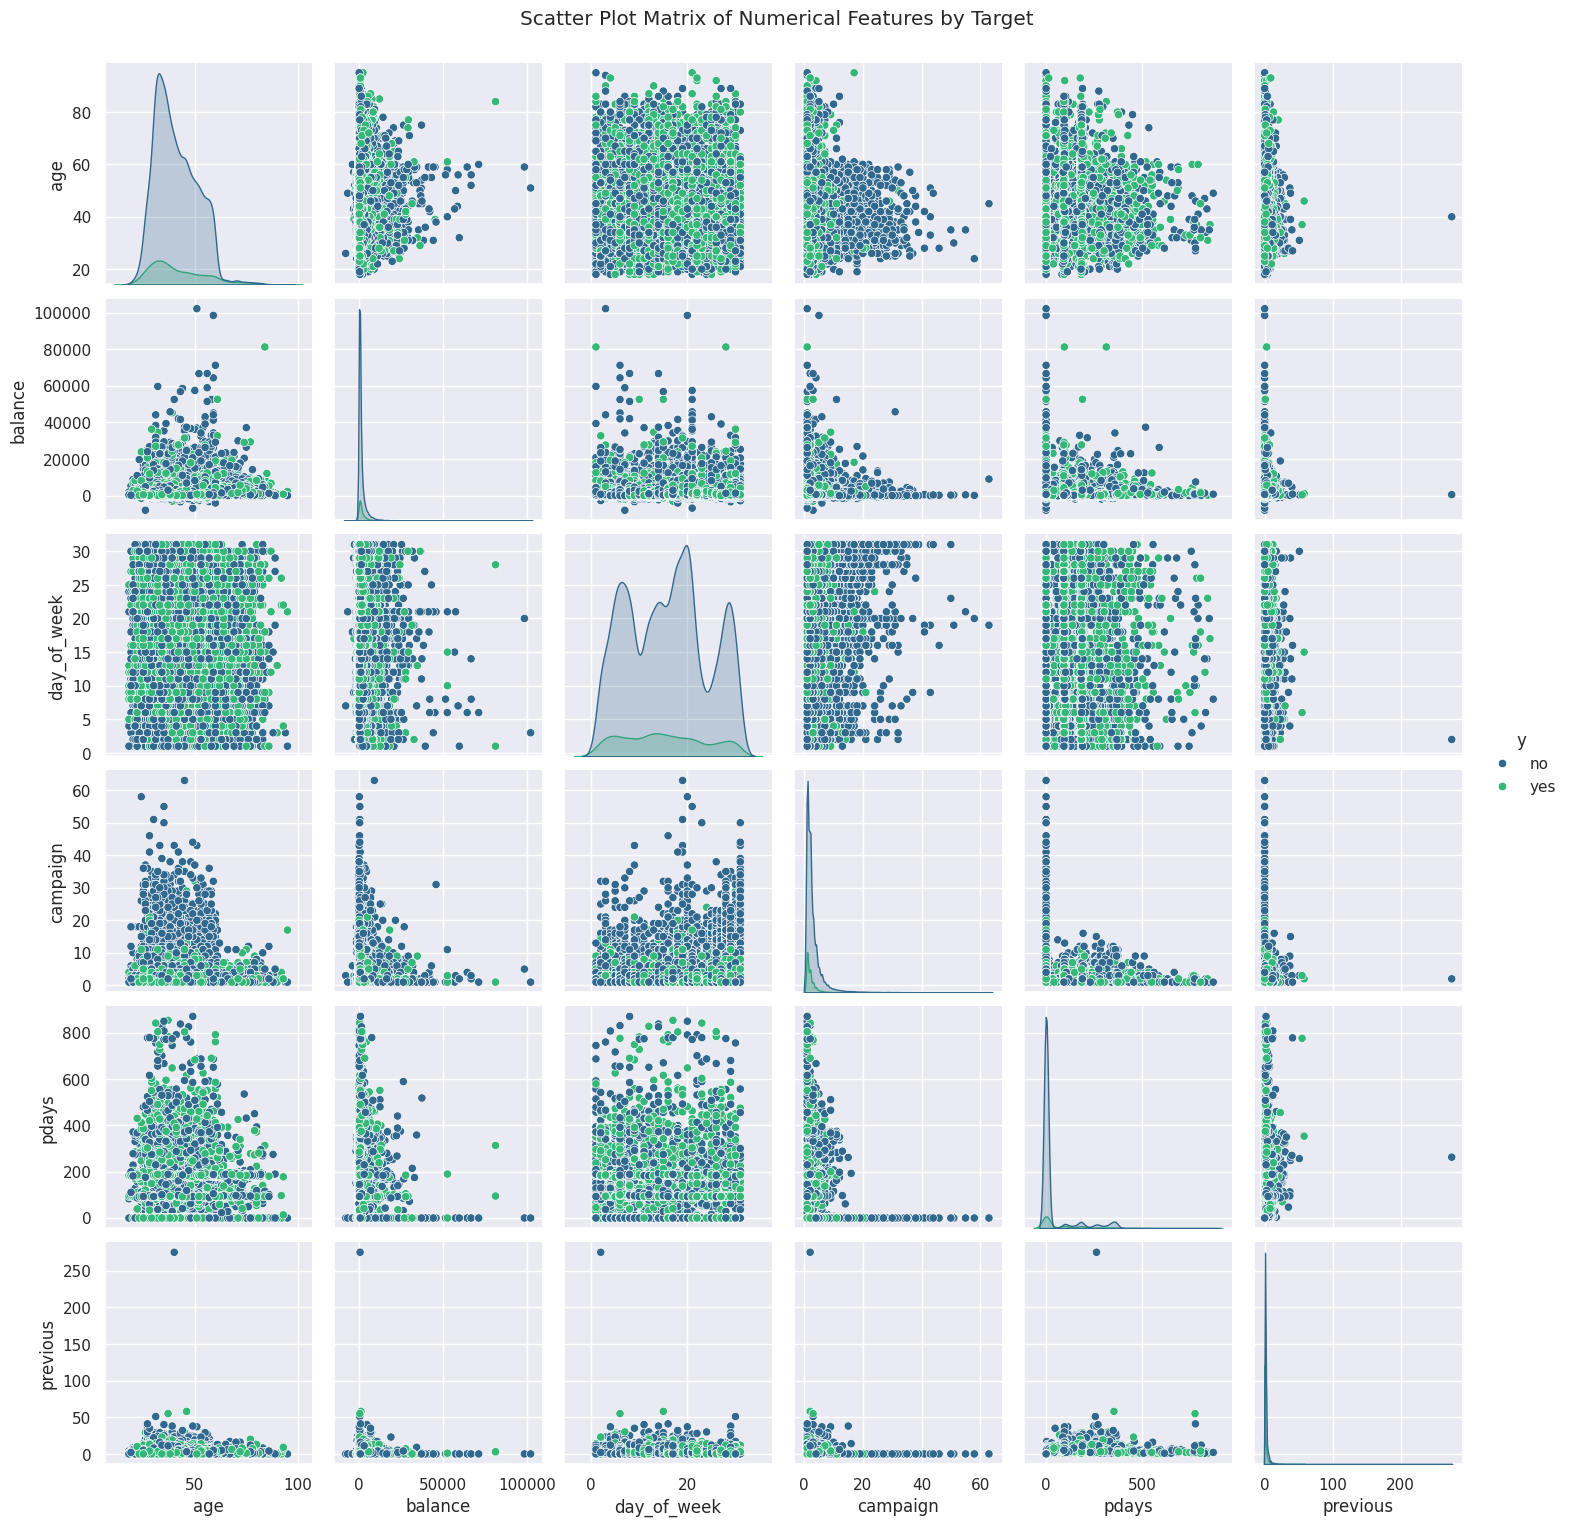

In [19]:
# Calculate the correlation matrix for numerical features
correlation_matrix = X[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Create a scatter plot matrix for numerical features, colored by the target variable
sns.pairplot(X[numerical_cols].join(y), hue='y', diag_kind='kde', palette='viridis')
plt.suptitle('Scatter Plot Matrix of Numerical Features by Target', y=1.02)
plt.show()

**Findings:**

1.   pdays and previous show some relationship in the scatter plot matrix, and pdays has a moderate correlation with previous. The -1 value in pdays indicates no previous contact, which is very common in the dataset.
2.  Other numerical features like age, balance, and campaign show less clear individual linear relationships with the outcome in the scatter plots, but their distributions and interactions might still be important.

3. Only pday and previous have significant correlation, and we have to see how this may help us.

### Additional Visualizations for Feature-Target Relationships

#### Box plots for Numerical Features by Target

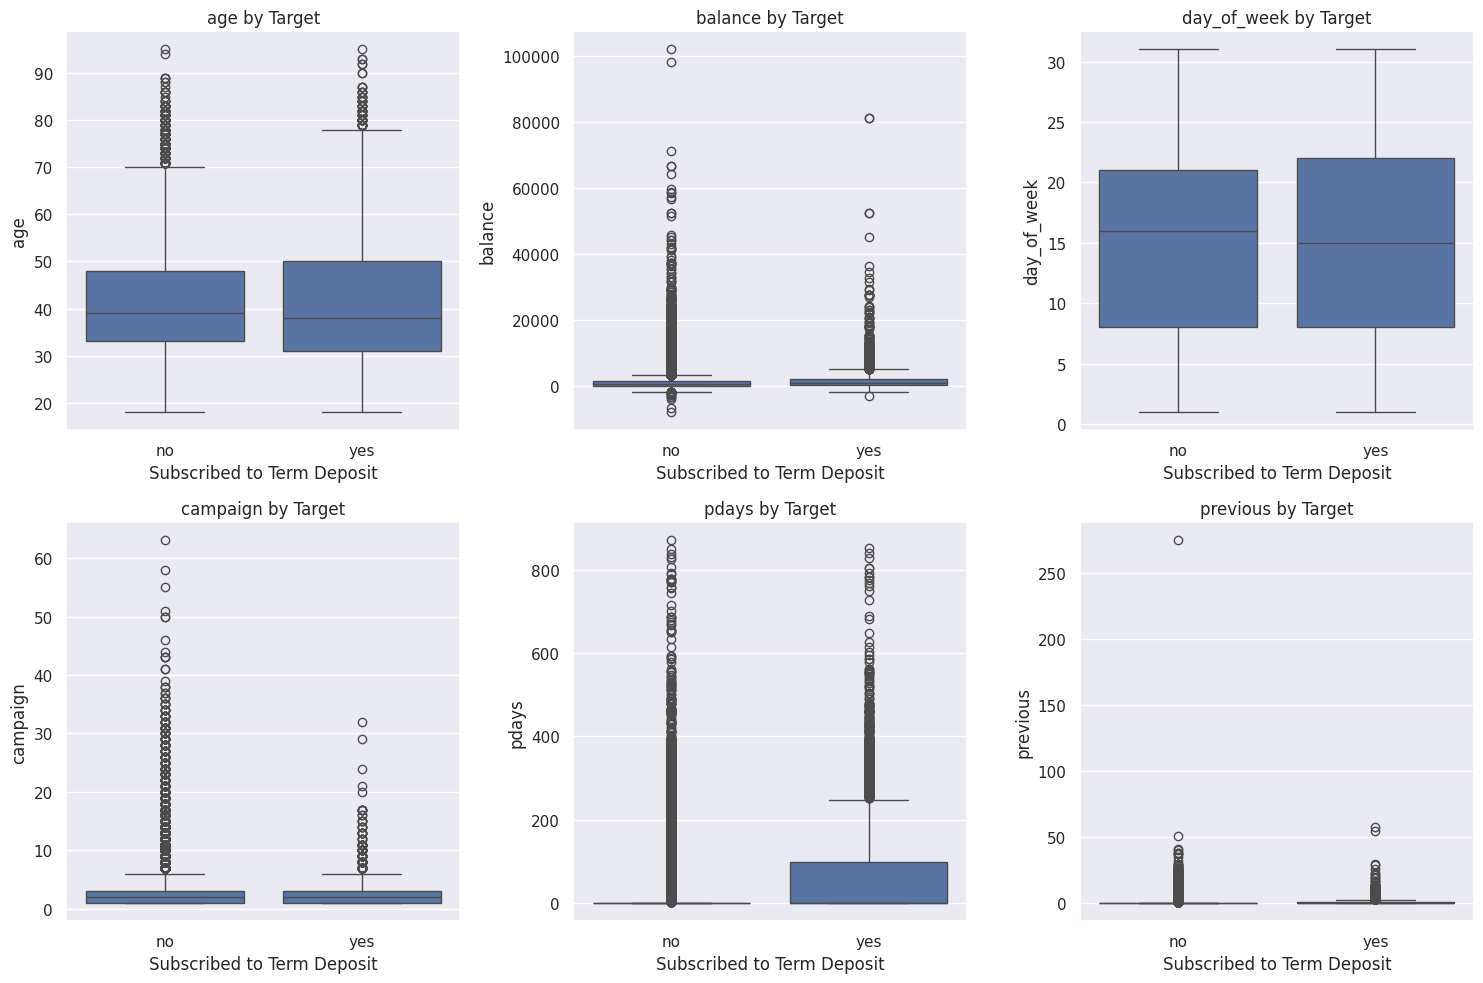

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine the number of rows and columns for the grid
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create box plots for numerical features by target in a grid
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=X.join(y), x='y', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Target')
    axes[i].set_xlabel('Subscribed to Term Deposit')
    axes[i].set_ylabel(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Findings:**

These charts confirm that pdays is correlated with the outcome more than others.

#### Stacked Bar Charts for Categorical Features

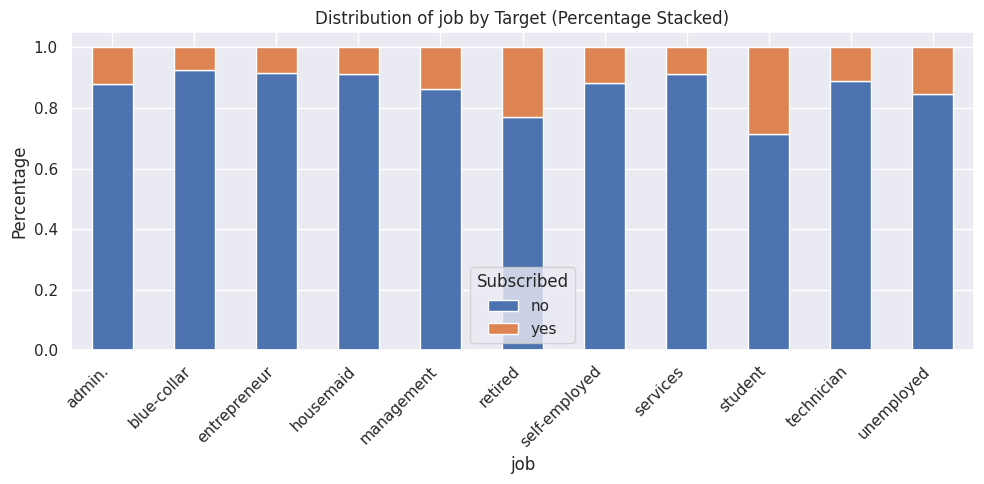

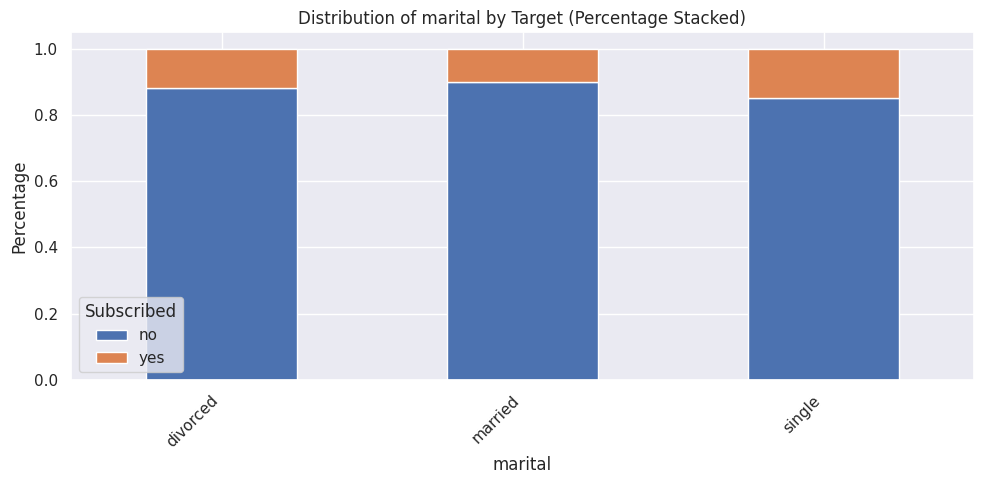

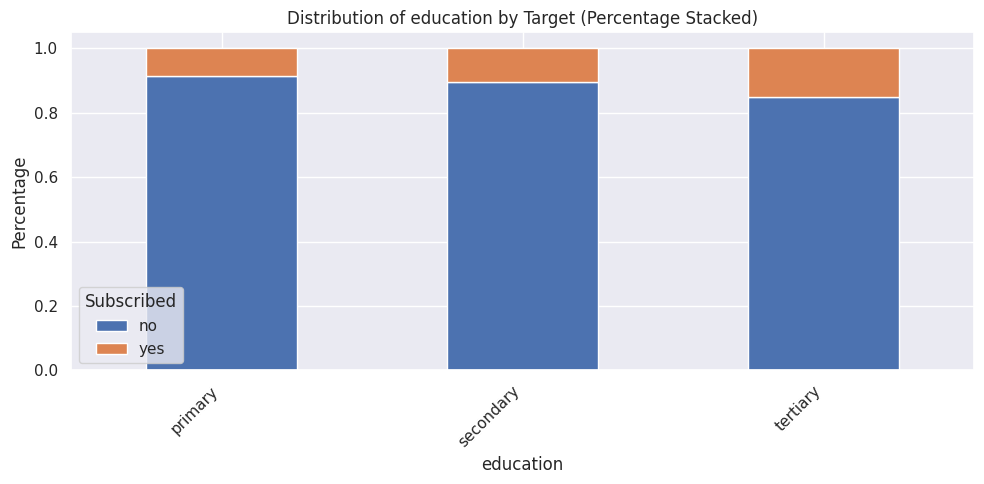

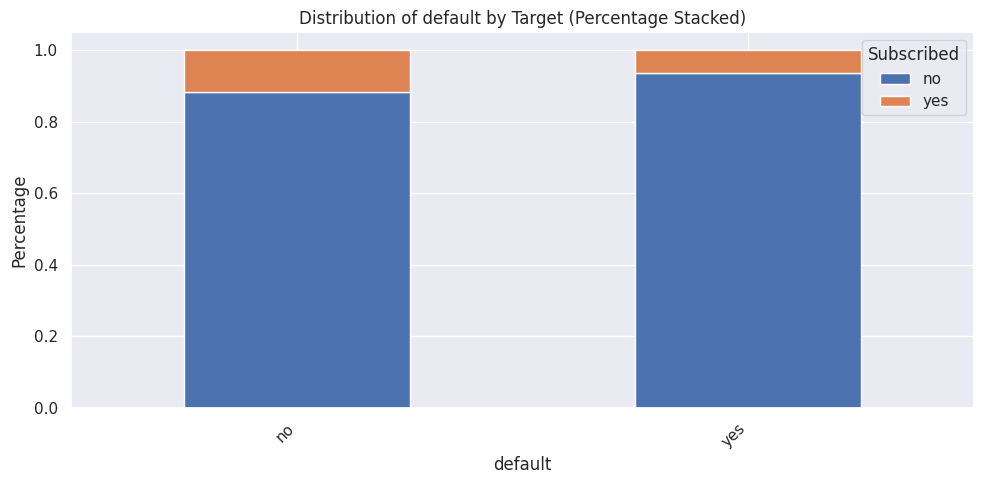

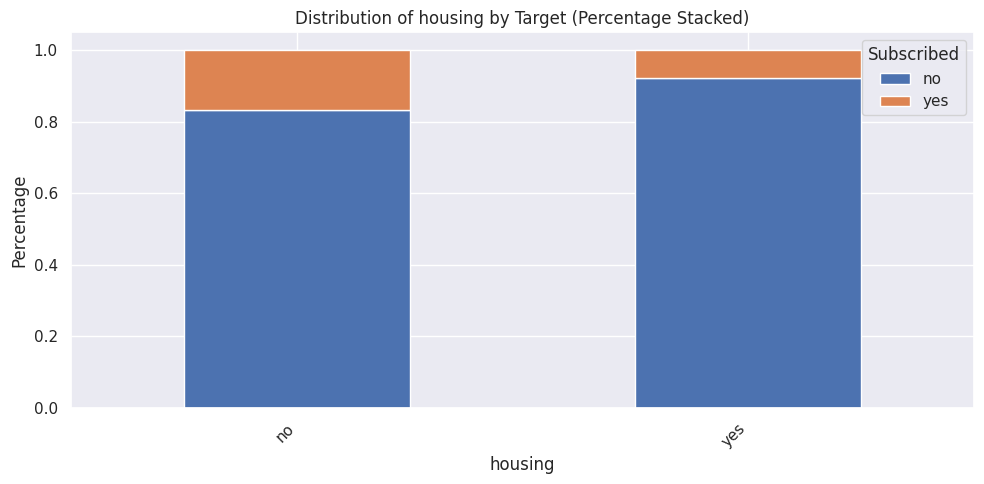

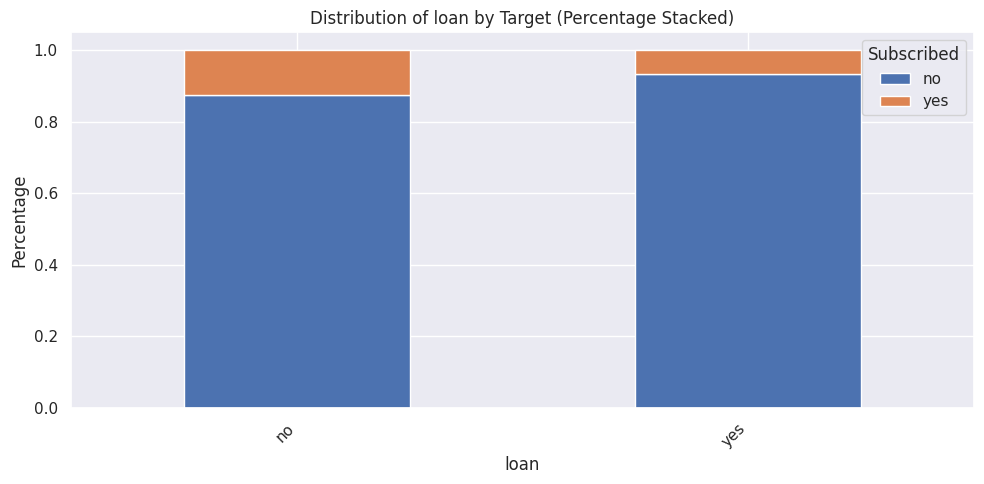

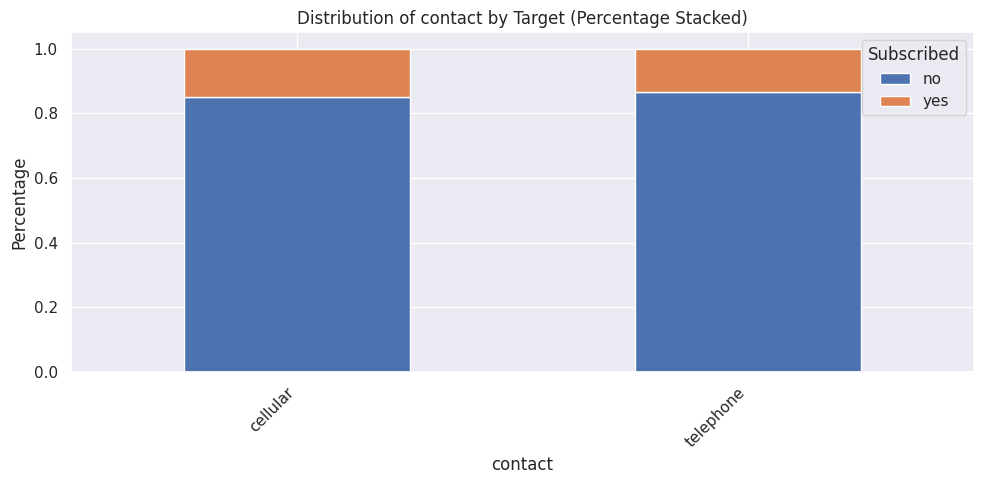

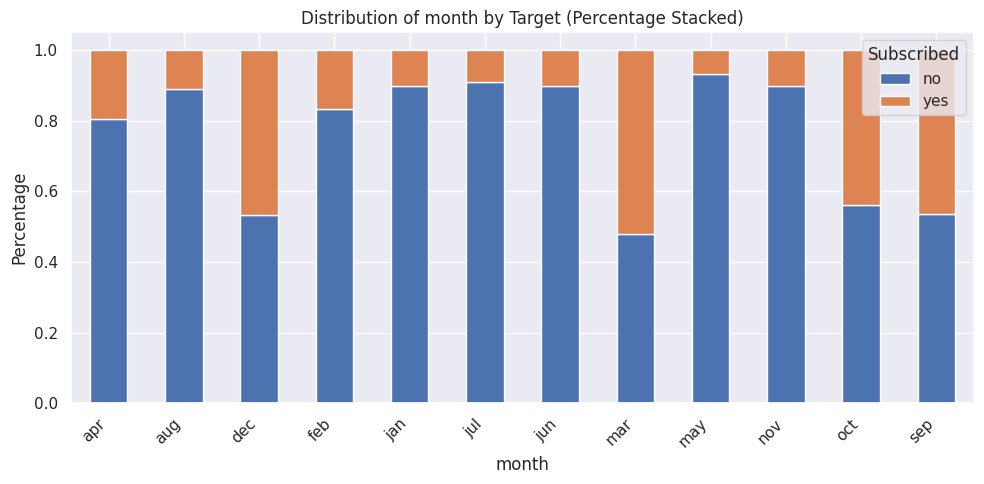

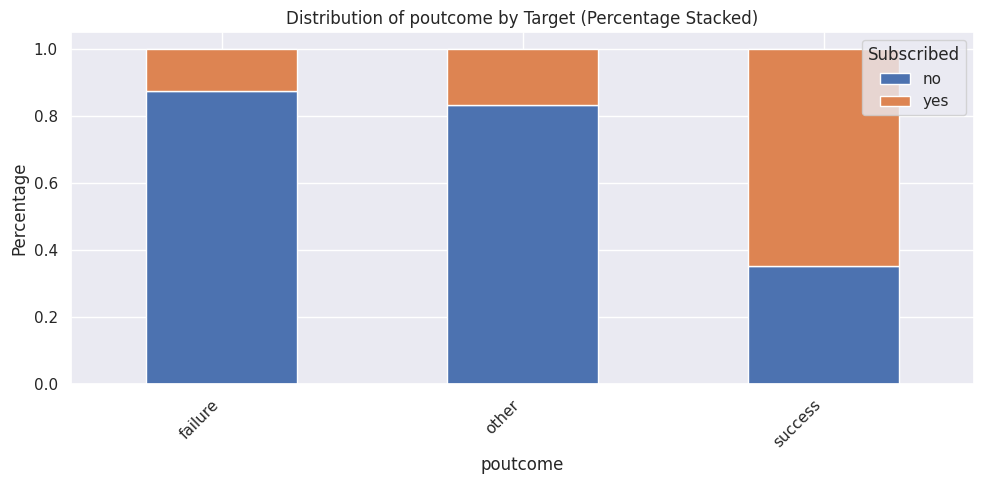

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Create percentage stacked bar charts for categorical features
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    # Create a crosstab of the feature and target and normalize to get percentages
    ct = pd.crosstab(X[col], y['y'], normalize='index')
    # Plot as a stacked bar chart
    ct.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Distribution of {col} by Target (Percentage Stacked)')
    plt.xlabel(col)
    plt.ylabel('Percentage')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Subscribed')
    plt.tight_layout()
    plt.show()

**Findings:**

1. Retired and students are more likely to subscribe.

2. People with no default are more likely to open account.

3. Those who don't have loans are more likely to subscribe.

4. Dec, Mar, Oct and Sept has more subscribers.

5. poutcome = SUCCESS is correlated with opening account.

# 4. Missing Values and Outliers

We do two different things in this section. First we check the missing values and think if there are any specific ways we should handle them, and then we check for outlier values to see if we should rule those out of our model.

### Missing Values

In [22]:
# Check for missing values before handling
print("Missing values before handling:")
print(X.isnull().sum())

Missing values before handling:
age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64


**Note:**
It seems there are not very many missing values except for poutcome variable, and it is expected, since most people haven't been contacted before. It is worth looking at poutcome and pdays = -1. As we see below, poutcome has values for most of those rows that pdays is not -1. Therefore we are going to treat all of missing values with standard simple imputer (mean or mode of the variable), and create some dummy variable for pdays=-1 variable, since it has special meaning.

In [23]:
# Select 'poutcome' values for rows where 'pdays' is -1
poutcome_for_pdays_neg_one = X.loc[X['pdays'] == -1, 'poutcome']
poutcome_for_pdays_not_neg_one = X.loc[X['pdays'] != -1, 'poutcome']

# Display the distribution of 'poutcome' for these rows
print("Distribution of 'poutcome' where 'pdays' is -1:")
display(poutcome_for_pdays_not_neg_one.value_counts(dropna=False))

# Display the distribution of 'poutcome' for these rows
print("Distribution of 'poutcome' where 'pdays' is -1:")
display(poutcome_for_pdays_neg_one.value_counts(dropna=False))

Distribution of 'poutcome' where 'pdays' is -1:


,count
poutcome,
failure,4901
other,1840
success,1511
NaN,5


Distribution of 'poutcome' where 'pdays' is -1:


,count
poutcome,
NaN,36954


### Outliers

Let's take a look at the high values of the skewed variables. As we look into them, there is nothing that is strikingly different except for the top value of previous variable. But as it doesn't have much impact, we'll leave it be.

In [24]:
# Select the columns of interest
columns_to_sort = ['balance', 'campaign', 'previous', 'pdays']

# Create a dictionary to store the top 20 values for each column
top_10_data = {}

# Iterate through the columns, sort values, and store the top 20
for col in columns_to_sort:
    top_10_data[col] = X[col].sort_values(ascending=False).head(10).reset_index(drop=True)

# Create a DataFrame from the collected top 20 values
top_10_df = pd.DataFrame(top_10_data)

print("Top 20 largest values for selected numerical columns (side by side):")
display(top_10_df)

Top 20 largest values for selected numerical columns (side by side):


,balance,campaign,previous,pdays
0,102127,63,275,871
1,98417,58,58,854
2,81204,55,55,850
3,81204,51,51,842
4,71188,50,41,838
5,66721,50,40,831
6,66653,46,38,828
7,64343,44,38,826
8,59649,43,37,808
9,58932,43,37,805


# 5. Feature Engineering

Before building the preprocessing pipeline, we are going to create some variables. We are focused on numeric variables because for categorical features tree models that we'll use heavily later, can take care of the combination based on AND/OR structure. Tree structures may also handle ratio variables, but we include them here nonetheless, as our current features are weak, and we are trying to squeeze everything out of them.

/tmp/ipython-input-25-931725541.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


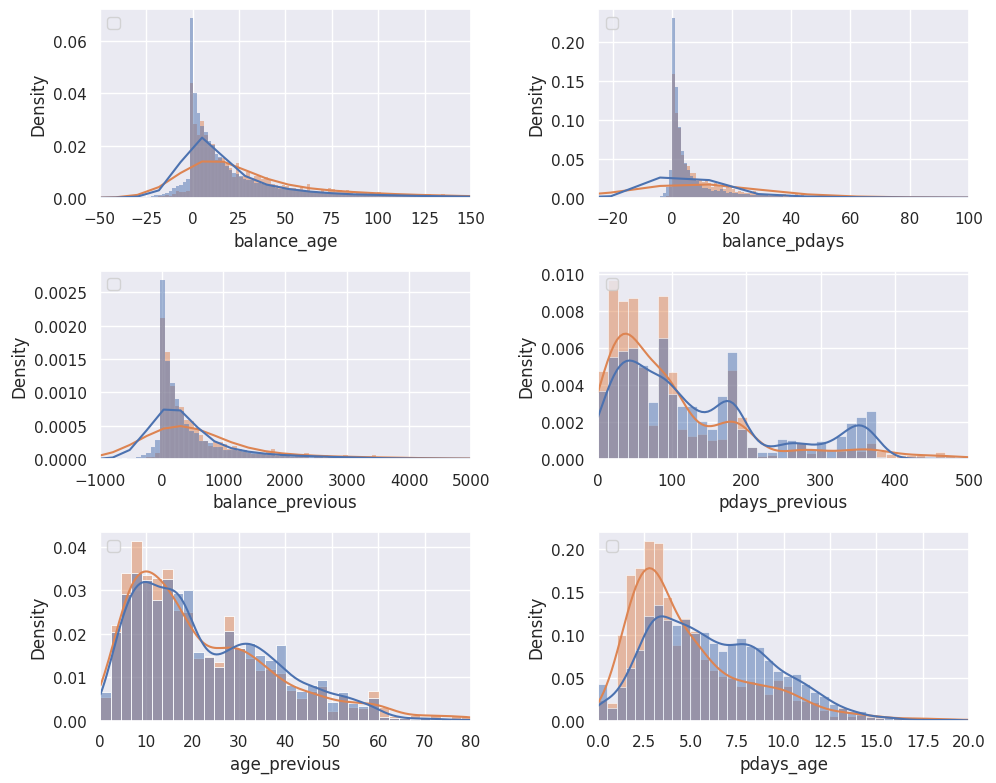

In [25]:
X['balance_age'] = X['balance'] / X['age']
X['balance_pdays'] = X['balance'] / X['pdays'].replace(-1, np.nan)
X['balance_previous'] = X['balance'] / X['previous']
X['pdays_previous'] = X['pdays'].replace(-1, np.nan) / X['previous']
X['age_previous'] = X['age'] / X['previous']
X['pdays_age'] = X['pdays'].replace(-1, np.nan) / X['age']

data = X.join(y)
fig, axes = plt.subplots(3, 2, figsize=(10, n_rows * 4))

axes = axes.flatten()

sns.histplot(data=data, x='balance_age', hue='y', kde=True, stat="density", common_norm=False, ax=axes[0])
axes[0].set_xlim(-50, 150)

sns.histplot(data=data, x='balance_pdays', hue='y', kde=True, stat="density",common_norm=False,  ax=axes[1])
axes[1].set_xlim(-25, 100)

sns.histplot(data=data, x='balance_previous', hue='y', kde=True, stat="density", common_norm=False, ax=axes[2])
axes[2].set_xlim(-1000, 5000)

sns.histplot(data=data, x='pdays_previous', hue='y', kde=True, stat="density", common_norm=False, ax=axes[3])
axes[3].set_xlim(0, 500)


sns.histplot(data=data, x='age_previous', hue='y', kde=True, stat="density", common_norm=False, ax=axes[4])
axes[4].set_xlim(0,80)


sns.histplot(data=data, x='pdays_age', hue='y', kde=True, stat="density", common_norm=False, ax=axes[5])
axes[5].set_xlim(0, 20)

for ax in axes:
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Of these only pdays_age seems very strong, the others less so.

# 6. Train-Test Split

In [26]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape (X_train):", X_train.shape)
print("Testing set shape (X_test):", X_test.shape)
print("Training set shape (y_train):", y_train.shape)
print("Testing set shape (y_test):", y_test.shape)

Training set shape (X_train): (36168, 22)
Testing set shape (X_test): (9043, 22)
Training set shape (y_train): (36168, 1)
Testing set shape (y_test): (9043, 1)


# 7. Preprocessing

We want to do the following in the preprocessing pipeline:



1.   Transformation of skewed variables
2.   One hot encoding the categorical variables
3.   Renaming some variables like day_of_week.
4.   Creating new variables:
        * pdays: the -1 value should be replaced by NaN
        * contacted_previously: a binary variable that is 1 when pdays != -1
        * day_of_month: renaming day_of_week to day_of_month
        * creating following new variables. Of course if they are not predicitive we'll drop them.
             
            * balance_age: detects if somebody has more balance for his age.     
            * balance_pdays: ratio of balance/pdays
            * balance_previous: ratio of balance to previous
            * pdays_age: pdays/age
            * age_previous: age/previous
            * pdays_previous: pdays/previous

5.   Dropping variables "duration" and "campaign" because the value of these variables is not known beforehand, and the goal of this model is to rank-order the prospects so that we can start with the marketing campaign. However if somebody wants to use this variable for an optimization after the campaign started, one can include it in this model.

6.   For variables that are right skewed we are going to do power transformation. It inlucdes: balance_age, balance_pdays, balance_previous, balance, campaign, previous, pdays.




### Pipeline for features

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.columns_)

        # Replace pdays = -1 with NaN
        X['pdays'] = X['pdays'].replace(-1, np.nan)

        # Binary variable
        X['contacted_previously'] = X['pdays'].notna().astype(int)

        # Rename day_of_week → day_of_month
        if 'day_of_week' in X.columns:
            X.rename(columns={'day_of_week': 'day_of_month'}, inplace=True)

        # Interaction features
        X['balance_age'] = X['balance'] / (X['age'] + 1e-5)
        X['balance_pdays'] = X['balance'] / (X['pdays'] + 1e-5)
        X['balance_previous'] = X['balance'] / (X['previous'] + 1e-5)
        X['pdays_age'] = X['pdays'] / (X['age'] + 1e-5)
        X['age_previous'] = X['age'] / (X['previous'] + 1e-5)
        X['pdays_previous'] = X['pdays'] / (X['previous'] + 1e-5)

        # Drop leakage
        for col in ['duration', 'campaign']:
            if col in X.columns:
                X.drop(columns=[col], inplace=True)

        # Save column names
        self.columns_ = X.columns.tolist()
        return X

    def get_feature_names_out(self, input_features=None):
        return np.array(self.columns_)


In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder

# These are the columns to power transform
skewed_cols = [
    'balance_age', 'balance_pdays', 'balance_previous',
    'balance', 'previous', 'pdays'
]

# Categorical columns to be one-hot encoded
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                    'contact', 'month', 'day_of_month', 'poutcome']

other_numeric_cols = [
    'age', 'contacted_previously',
    'pdays_age', 'age_previous', 'pdays_previous'
]

# --------------------------
# ColumnTransformer
# --------------------------

column_transformer = ColumnTransformer(transformers=[
    ('skewed', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('power', PowerTransformer())
    ]), skewed_cols),

    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), other_numeric_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
], remainder='drop')  # nothing escapes unmanaged

# --------------------------
# Final Pipeline
# --------------------------

preprocessor = Pipeline([
    ('feature_engineering', FeatureEngineer()),
    ('column_transformer', column_transformer)
])

### Encoding Target Variable

In [29]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Initialize LabelEncoder
label_encoder = LabelEncoder()

In [30]:
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
y_train_transformed = label_encoder.fit_transform(y_train.values.ravel())
y_test_transformed = label_encoder.transform(y_test.values.ravel())

In [31]:
preprocessor.get_feature_names_out().shape

(86,)

# 8. Feature Selection

We do feature selection in two steps since we have many variables. First we filter with "select from model" from sklearn to narrow the search and then finally we use RFECV and RFE to get the best feature set.

"select from model" works by getting feature importance of all variables based on our model of choice (Random Forest) in this notebook, and then uses a threshold for finding the best set of features.

We use "select from model" and feature importance to make sure we don't rule out any variable that may be important in interaction with others.

### Select From Model

We use Random Forest to do feature importance of the variables and select from them. The choice is made because Random Forest gives feature importance vector, and also it is less prone or sensitive to overfitting and other problems, and is very rorbust.

In [32]:
X_temp = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())

In [33]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

sfm = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
sfm.fit(X_temp, y_train.values.ravel())
sfm_selected_mask = sfm.get_support()
sfm_selected_features = X_temp.columns[sfm_selected_mask].tolist()

In [34]:
print("Final selected features after SelectFromModel:")
print(sfm_selected_features)

Final selected features after SelectFromModel:
['skewed__balance_age', 'skewed__balance_pdays', 'skewed__balance_previous', 'skewed__balance', 'skewed__previous', 'skewed__pdays', 'num__age', 'num__pdays_age', 'num__age_previous', 'num__pdays_previous', 'cat__education_secondary', 'cat__housing_no', 'cat__housing_yes', 'cat__poutcome_success']


In [35]:
print("Number of selected features:")
print(len(sfm_selected_features))

Number of selected features:
14


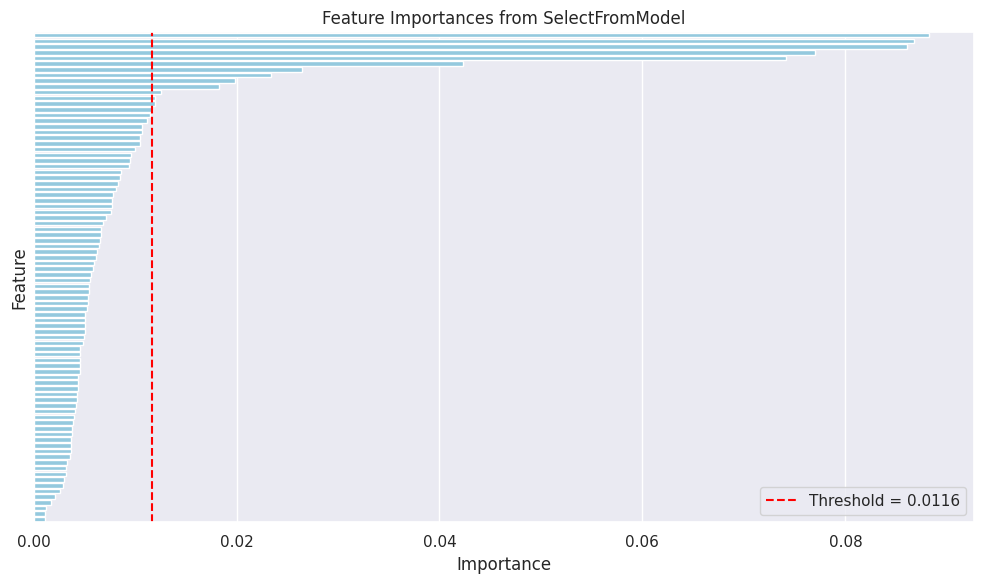

In [36]:
# Get importances and threshold
importances = sfm.estimator_.feature_importances_
threshold = sfm.threshold_

# Combine into DataFrame
importance_df = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', color='skyblue')
# Add threshold line
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Feature Importances from SelectFromModel')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
importance_df.head()

,feature,importance
0,skewed__balance_age,0.088262
1,skewed__balance,0.086753
2,skewed__balance_previous,0.086112
3,num__age_previous,0.076959
4,num__age,0.074146


/tmp/ipython-input-38-10667506.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


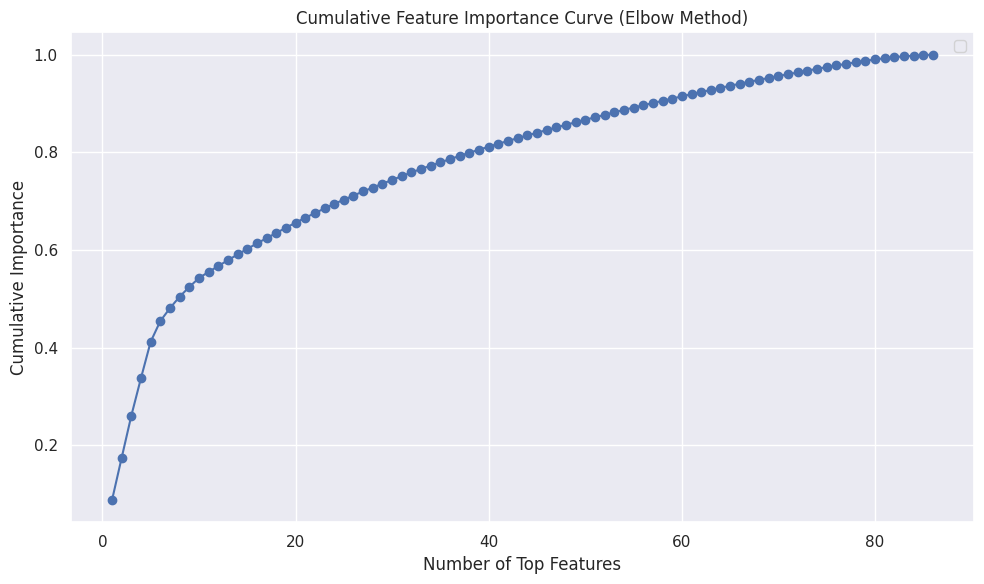

In [38]:
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(importance_df) + 1),
         importance_df['cumulative_importance'], marker='o')

plt.xlabel('Number of Top Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance Curve (Elbow Method)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

If we're looking for an elbow in the curve, then something around 10 should be fine according to this.

### Recursive feature extraction (RFE)

Now that we have reduced the variables by four folds (from 86 to 22), which from the graph seems reasonable enough, we do RFECV and RFE to get the final list of good variables. We use RFE because it is very comprehensive method, and it would be less likely that we come up with some suboptimized selection.

In [39]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# --- Step 1: Subset the selected features from earlier step ---
X_sfm_selected = X_temp[sfm_selected_features]

# --- Step 2: Setup RFECV ---
estimator = RandomForestClassifier(n_estimators=40, max_depth=15, random_state=42)
cv = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=estimator,
              step=1,
              cv=cv,
              scoring='average_precision',
              n_jobs=-1,
              verbose=1)

# --- Step 3: Fit RFECV ---
rfecv.fit(X_sfm_selected, y_train_transformed.ravel())

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_depth=15, n_estimators=40,
                                       random_state=42),
      n_jobs=-1, scoring='average_precision', verbose=1)

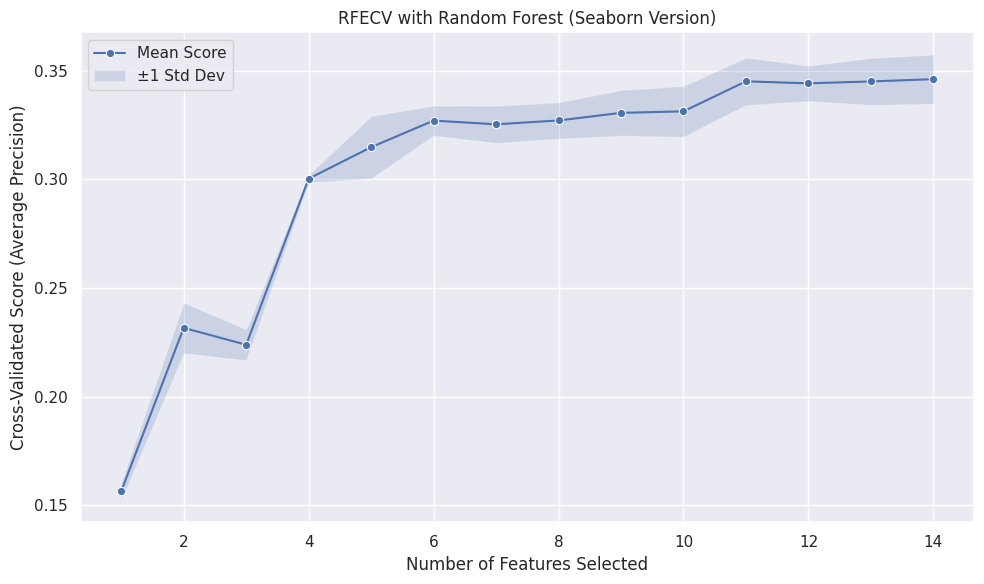

In [40]:
# Build DataFrame from RFECV results
mean_scores = rfecv.cv_results_['mean_test_score']
std_scores = rfecv.cv_results_['std_test_score']
n_features = range(1, len(mean_scores) + 1)

rfecv_df = pd.DataFrame({
    'n_features': n_features,
    'mean_score': mean_scores,
    'lower': mean_scores - std_scores,
    'upper': mean_scores + std_scores
})

# Seaborn lineplot with confidence band
plt.figure(figsize=(10, 6))
sns.lineplot(data=rfecv_df, x='n_features', y='mean_score', marker='o', label='Mean Score')
plt.fill_between(rfecv_df['n_features'], rfecv_df['lower'], rfecv_df['upper'], alpha=0.2, label='±1 Std Dev')

plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated Score (Average Precision)")
plt.title("RFECV with Random Forest (Seaborn Version)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
rfecv_df

,n_features,mean_score,lower,upper
0,1,0.156584,0.152528,0.160639
1,2,0.231688,0.220096,0.243280
2,3,0.223917,0.216800,0.231034
3,4,0.300308,0.298557,0.302058
4,5,0.314774,0.300478,0.329071
5,6,0.327018,0.320143,0.333894
6,7,0.325305,0.316777,0.333834
7,8,0.327071,0.318752,0.335390
8,9,0.330568,0.320102,0.341034
9,10,0.331263,0.319609,0.342917


We see that 6 or 11 features is the best. Unfortunately RFECV doesn't give the variable names for 6 or 11 feature set. So we use RFE to pull it manually.

In [42]:
from sklearn.feature_selection import RFE

# Base estimator
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)

# Create RFE selector
rfe = RFE(estimator=estimator, n_features_to_select=11, step=1, verbose=1)
rfe.fit(X_sfm_selected, y_train.values.ravel())

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


RFE(estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                     random_state=42),
    n_features_to_select=11, verbose=1)

In [43]:
# Get selected feature names
rfe_selected_11 = X_sfm_selected.columns[rfe.support_].tolist()

print("Top 11 features selected by RFE:")
print(rfe_selected_11)

Top 11 features selected by RFE:
['skewed__balance_age', 'skewed__balance_pdays', 'skewed__balance_previous', 'skewed__balance', 'skewed__pdays', 'num__age', 'num__pdays_age', 'num__age_previous', 'num__pdays_previous', 'cat__housing_no', 'cat__poutcome_success']


In [44]:
X_selected_11 = X_temp[rfe_selected_11]

In [45]:
rfe = RFE(estimator=estimator, n_features_to_select=6, step=1, verbose=1)
rfe.fit(X_selected_11, y_train.values.ravel())

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.


RFE(estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                     random_state=42),
    n_features_to_select=6, verbose=1)

In [46]:
# Get selected feature names
rfe_selected_6 = X_selected_11.columns[rfe.support_].tolist()

print("Top 6 features selected by RFE:")
print(rfe_selected_6)

Top 6 features selected by RFE:
['skewed__balance_age', 'skewed__balance_previous', 'skewed__balance', 'num__age', 'num__age_previous', 'cat__poutcome_success']


In [47]:
import pickle
pickle.dump(rfe_selected_6, open('rfe_selected_6.pkl', 'wb'))
pickle.dump(rfe_selected_11, open('rfe_selected_11.pkl', 'wb'))

In [48]:
import pickle
rfe_selected_6 = pickle.load(open('rfe_selected_6.pkl', 'rb'))
rfe_selected_11 = pickle.load(open('rfe_selected_11.pkl', 'rb'))

# 9. Model Training


### Defining new scoring function

F1 score and average precision score should be good metrics to measure the performance of the models, but since the model is going to be used in marketing, and we need to make sure that the top x% of the population have the most account openers, we define the following top_precision scorer to compare our models.

It is standard practice in marketing to reach out to top scored population, and for that we think a default value of 2% is sufficient, which would give 2M calls for 100M people scored, which may not be a bad estimate, especially for Direct Mail marketing. This threshold of course can be lowered as the campaign is going to be used for telephone marketing.

In [49]:
def precision_at_top_k(y_true, y_scores, k=0.02):
    n_top = int(len(y_scores) * k)
    top_indices = np.argsort(y_scores)[::-1][:n_top]
    y_true_top = y_true[top_indices]
    tp = np.sum(y_true_top == 1)
    precision = tp / n_top if n_top > 0 else 0.0
    return precision


def top_k_precision(estimator, X, y):
    y_scores = estimator.predict_proba(X)[:, 1]  # Use probability for class 1
    return precision_at_top_k(y, y_scores, k=0.02)

### Logistic Regression

In [50]:
from sklearn.preprocessing import FunctionTransformer

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

selected_indices = np.where(np.isin(feature_names, rfe_selected_11))[0]

def select_by_index(X):
  if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
  return X[:, selected_indices]

selector = FunctionTransformer(select_by_index, validate=False)

In [51]:
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, average_precision_score, make_scorer)
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from imblearn.pipeline import Pipeline as imbPipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'average_precision': make_scorer(average_precision_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'top_k_precision': top_k_precision
}

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline as imbPipeline

# Define pipeline
lr_pipeline = imbPipeline([
    ('feature_engineering', FeatureEngineer()),
    ('column_transformer', column_transformer),
    ('feature_selector', selector),  # assumes selector is defined
    ('classifier', LogisticRegression(
        solver='lbfgs',         # good for small/medium datasets
        max_iter=1000,          # increase iterations to ensure convergence
        class_weight='balanced',# handle imbalance
        random_state=42
    ))
])

# Perform cross-validation
cv_results = cross_validate(lr_pipeline, X_train, y_train_transformed,
                            cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True)

# Print results
for metric in scoring.keys():
    print(f"{metric.upper()} - Train: {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"{metric.upper()} - Test : {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")
    print()


ACCURACY - Train: 0.6840 ± 0.0131
ACCURACY - Test : 0.6825 ± 0.0157

F1 - Train: 0.3108 ± 0.0025
F1 - Test : 0.3083 ± 0.0048

AVERAGE_PRECISION - Train: 0.1728 ± 0.0010
AVERAGE_PRECISION - Test : 0.1713 ± 0.0025

ROC_AUC - Train: 0.6514 ± 0.0009
ROC_AUC - Test : 0.6486 ± 0.0035

PRECISION - Train: 0.2088 ± 0.0043
PRECISION - Test : 0.2071 ± 0.0058

RECALL - Train: 0.6088 ± 0.0182
RECALL - Test : 0.6044 ± 0.0197

TOP_K_PRECISION - Train: 0.6917 ± 0.0073
TOP_K_PRECISION - Test : 0.6917 ± 0.0189



This model is actually not bad, better than we expected. This says top_k_precision is something like 70%, which means out of top 2% of the population 70% open accounts which is **VERY GOOD**.

In [53]:
import statsmodels.api as sm


X_sm = lr_pipeline[:-1].transform(X_train)  # everything except classifier

X_sm = sm.add_constant(X_sm)

# Fit logistic regression with statsmodels
model_sm = sm.Logit(y_train_transformed, X_sm).fit()

# Get summary with coefficients, p-values, and confidence intervals
print(model_sm.summary())

Optimization terminated successfully.
         Current function value: 0.322551
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                36168
Model:                          Logit   Df Residuals:                    36156
Method:                           MLE   Df Model:                           11
Date:                Wed, 16 Jul 2025   Pseudo R-squ.:                  0.1062
Time:                        18:39:20   Log-Likelihood:                -11666.
converged:                       True   LL-Null:                       -13052.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6345      0.028    -93.501      0.000      -2.690      -2.579
x1             0.4161      0.

In [54]:
names_with_const = ['Intercept'] + list(rfe_selected_11)
summary_table = model_sm.summary2().tables[1]
summary_table.index = names_with_const

In [55]:
summary_table

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-2.634544,0.028177,-93.500522,0.000000e+00,-2.689769,-2.579318
skewed__balance_age,0.416057,0.068072,6.112019,9.837839e-10,0.282639,0.549476
skewed__balance_pdays,-0.013983,0.013178,-1.061143,2.886249e-01,-0.039811,0.011844
skewed__balance_previous,-0.071244,0.036752,-1.938512,5.256081e-02,-0.143277,0.000788
skewed__balance,-0.177167,0.074218,-2.387119,1.698099e-02,-0.322631,-0.031703
skewed__pdays,-0.075726,0.034825,-2.174441,2.967204e-02,-0.143983,-0.007469
num__age,0.130088,0.022451,5.794164,6.866253e-09,0.086083,0.174092
num__pdays_age,0.111953,0.034045,3.288379,1.007659e-03,0.045226,0.178680
num__age_previous,-0.229726,0.021985,-10.449127,1.478807e-25,-0.272816,-0.186636
num__pdays_previous,-0.023355,0.020492,-1.139681,2.544192e-01,-0.063519,0.016809


As we will see in next models, the performance of logistic regression is very good, so we can safely use these coefficients to understand how these variables shape the outcome.

*   Here it is obvious that poutcome_success is
the most important variable. It is highly significant and with a large coefficient, which is comparable to othres because each variable is standardized.

*   The second most important variable is housing_no with direct impact. In other words if somebody doesn't have housing loan, it is more likely for them to open account, which makes sense.

*   balance/age is also significant with direct impact, which makes sense. If somebody is wealthy for his/her own age, they are more likely to open account.

### Random Forest

We love Random Forest! Yes we do! We love it because it is easy to train, gives feature importance, has high performance, and doesn't overfit that much, like XGBoost does.

But before we do, we mention that for model building we use SMOTE for model building, so that we can increase performance, as this data is imbalanced.

#### Adding SMOTE


For building model, since we have very imbalanced dataset, it is a good idea to add SMOTE to the pipeline first and compare the performance.

In [56]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

rf_pipeline = imbPipeline([
    ('feature_engineering', FeatureEngineer()),
    ('column_transformer', column_transformer),
    ('feature_selector', selector),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [57]:
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, average_precision_score, make_scorer)
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from imblearn.pipeline import Pipeline as imbPipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'average_precision': make_scorer(average_precision_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'top_k_precision': top_k_precision
}

# Perform cross-validation
import time
start_time = time.time()
cv_results = cross_validate(rf_pipeline, X_train, y_train_transformed, cv=cv,
                            scoring=scoring, n_jobs=-1, return_train_score=True)
end_time = time.time()

print(f"Time taken for cross-validation: {end_time - start_time:.2f} seconds")

Time taken for cross-validation: 103.91 seconds


In [58]:
for metric in scoring.keys():
    print(f"{metric.upper()} - Train: {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"{metric.upper()} - Test : {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")
    print()

ACCURACY - Train: 0.9890 ± 0.0004
ACCURACY - Test : 0.7727 ± 0.0032

F1 - Train: 0.9520 ± 0.0019
F1 - Test : 0.2817 ± 0.0081

AVERAGE_PRECISION - Train: 0.9142 ± 0.0035
AVERAGE_PRECISION - Test : 0.1576 ± 0.0037

ROC_AUC - Train: 0.9657 ± 0.0011
ROC_AUC - Test : 0.6028 ± 0.0063

PRECISION - Train: 0.9692 ± 0.0028
PRECISION - Test : 0.2235 ± 0.0065

RECALL - Train: 0.9354 ± 0.0021
RECALL - Test : 0.3810 ± 0.0119

TOP_K_PRECISION - Train: 1.0000 ± 0.0000
TOP_K_PRECISION - Test : 0.3153 ± 0.0129



It is clear that we have a severe case of overfitting. There are things we can do, and we are going to do some validation curves for random forest to see what the optimal values of paramters could be.

We don't do grid search here because the grid search does not tell us how the parameters change the performance of the model and we like to see some graphs that show us this relationship.

It is possible to add grid search to this model, but as the validation curves suggest, there is not much point in checking other combinations. Therefore we'll leave it there.

#### RF Validation Curves

In [59]:
from sklearn.model_selection import validation_curve

start_time = time.time()

param_range = np.arange(2, 7, 1)
rf_pipeline.set_params(classifier__n_estimators=30)
train_scores, test_scores = validation_curve(
    rf_pipeline, X_train, y_train_transformed, param_name="classifier__max_depth",
    param_range=param_range, cv=cv, scoring=top_k_precision, n_jobs=-1)

end_time = time.time()
print(f"Time taken for validation curve: {end_time - start_time:.2f} seconds")

Time taken for validation curve: 46.45 seconds


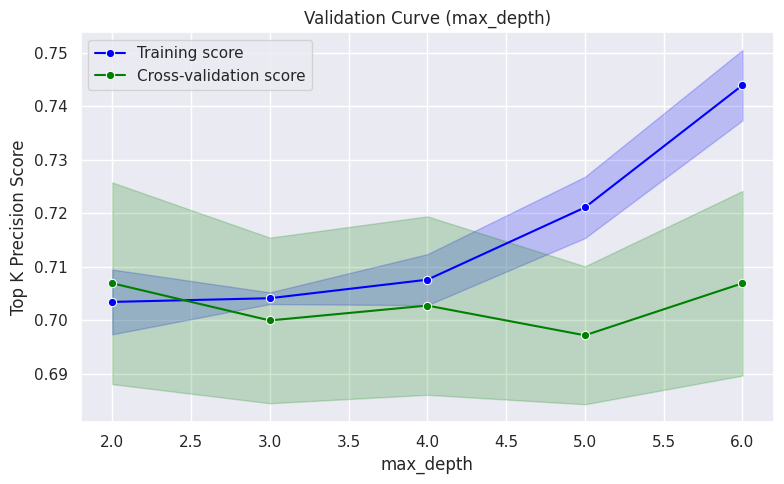

In [60]:
# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot mean with shaded std dev area
plt.figure(figsize=(8, 5))
sns.lineplot(x=param_range, y=train_scores_mean, label="Training score",
         marker='o', color='blue')
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')

sns.lineplot(x=param_range, y=test_scores_mean, label="Cross-validation score",
         marker='o', color='green')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color='green')

plt.title("Validation Curve (max_depth)")
plt.xlabel("max_depth")
plt.ylabel("Top K Precision Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

From here we get that max_depth should be 4. We update the RF pipeline with this variable and check for max_leaf_nodes.

In [61]:
start_time = time.time()

rf_pipeline.set_params(classifier__max_depth=4)

param_range = np.arange(30, 301, 30) # Range from 10 to 100 with step 10

train_scores, test_scores = validation_curve(
    rf_pipeline, X_train, y_train_transformed, param_name="classifier__max_leaf_nodes",
    param_range=param_range, cv=cv, scoring=top_k_precision, n_jobs=-1, verbose=1)

end_time = time.time()
print(f"Time taken for validation curve: {end_time - start_time:.2f} seconds")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Time taken for validation curve: 93.78 seconds


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


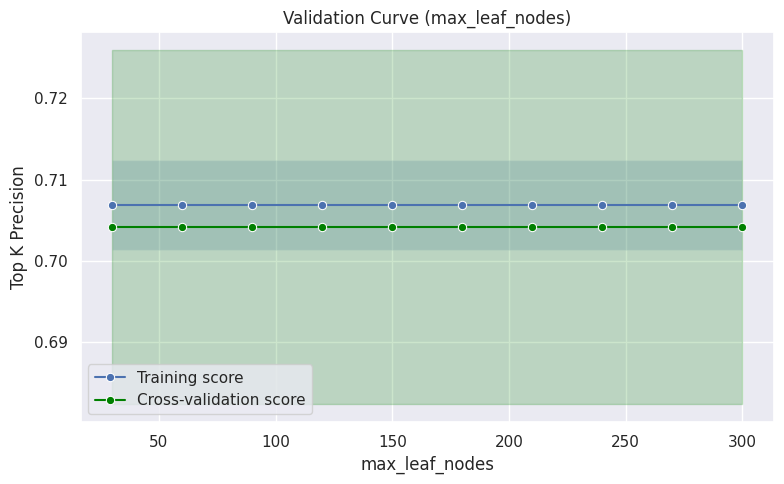

In [62]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
sns.lineplot(x=param_range, y=train_scores_mean, label="Training score",
             marker='o')
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
sns.lineplot(x=param_range, y=test_scores_mean, label="Cross-validation score",
             marker='o', color='green')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color='green')

plt.title("Validation Curve (max_leaf_nodes)")
plt.xlabel("max_leaf_nodes")
plt.ylabel("Top K Precision")
plt.legend()
plt.tight_layout()
plt.show()

It seems the model is not very sensitive to max_leaf_nodes. So we'll leave there and check the model once more.

In [63]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Perform cross-validation
rf_pipeline.set_params(classifier__max_depth=4)
cv_results = cross_validate(rf_pipeline, X_train, y_train_transformed, cv=cv,
                            scoring=scoring, n_jobs=-1, return_train_score=True)
for metric in scoring.keys():
    print(f"{metric.upper()} - Train: {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"{metric.upper()} - Test : {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")
    print()

ACCURACY - Train: 0.7943 ± 0.0356
ACCURACY - Test : 0.7913 ± 0.0372

F1 - Train: 0.3695 ± 0.0182
F1 - Test : 0.3592 ± 0.0177

AVERAGE_PRECISION - Train: 0.2061 ± 0.0116
AVERAGE_PRECISION - Test : 0.1998 ± 0.0112

ROC_AUC - Train: 0.6708 ± 0.0026
ROC_AUC - Test : 0.6626 ± 0.0070

PRECISION - Train: 0.2959 ± 0.0412
PRECISION - Test : 0.2890 ± 0.0422

RECALL - Train: 0.5096 ± 0.0505
RECALL - Test : 0.4947 ± 0.0561

TOP_K_PRECISION - Train: 0.7076 ± 0.0048
TOP_K_PRECISION - Test : 0.7028 ± 0.0167



**WOW THESE ARE GREAT RESULTS.** A marketing model with this top_k_precision can be very beneficial as 70% of the population that are marketed will open accounts. This model has greater F1 score than our logistic regression too.We'll see if we could do any different without SMOTE.

#### Model without SMOTE

In [64]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_no_smote = imbPipeline([
    ('feature_engineering', FeatureEngineer()),
    ('column_transformer', column_transformer),
    ('feature_selector', selector),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1,
                                          n_estimators=100, max_depth=4))
])


# Perform cross-validation
cv_results = cross_validate(rf_no_smote,
                            X_train, y_train_transformed, cv=cv,
                            scoring=scoring, n_jobs=-1, return_train_score=True)
for metric in scoring.keys():
    print(f"{metric.upper()} - Train: {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"{metric.upper()} - Test : {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")
    print()

ACCURACY - Train: 0.8943 ± 0.0002
ACCURACY - Test : 0.8930 ± 0.0012

F1 - Train: 0.2586 ± 0.0049
F1 - Test : 0.2493 ± 0.0161

AVERAGE_PRECISION - Train: 0.2119 ± 0.0017
AVERAGE_PRECISION - Test : 0.2051 ± 0.0084

ROC_AUC - Train: 0.5748 ± 0.0018
ROC_AUC - Test : 0.5716 ± 0.0056

PRECISION - Train: 0.7192 ± 0.0059
PRECISION - Test : 0.6959 ± 0.0204

RECALL - Train: 0.1577 ± 0.0039
RECALL - Test : 0.1520 ± 0.0114

TOP_K_PRECISION - Train: 0.7502 ± 0.0097
TOP_K_PRECISION - Test : 0.7083 ± 0.0186



This model performs well too, but we'll probably use the one with SMOTE, since it is more general purpose and has higher F1 score. For example if the business unit decides to reach out to more people, since we have more budget, it is better to have a model with higher overall performance namely F1 score.

#### Model With Balanced Weights

 Here we are going to check if changing the Random Forest weight parameter has any benefit. As we see below, using balanced weights is going to perform even better than SMOTE. Therefore we'll use this mode, as it is performing better and also it is simpler.

In [65]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_no_smote = imbPipeline([
    ('feature_engineering', FeatureEngineer()),
    ('column_transformer', column_transformer),
    ('feature_selector', selector),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1,
                                          n_estimators=100, max_depth=4,
                                          class_weight='balanced'))
])


# Perform cross-validation
rf_cv_results = cross_validate(rf_no_smote,
                            X_train, y_train_transformed, cv=cv,
                            scoring=scoring, n_jobs=-1, return_train_score=True)
for metric in scoring.keys():
    print(f"{metric.upper()} - Train: {rf_cv_results[f'train_{metric}'].mean():.4f} ± {rf_cv_results[f'train_{metric}'].std():.4f}")
    print(f"{metric.upper()} - Test : {rf_cv_results[f'test_{metric}'].mean():.4f} ± {rf_cv_results[f'test_{metric}'].std():.4f}")
    print()

ACCURACY - Train: 0.8141 ± 0.0269
ACCURACY - Test : 0.8105 ± 0.0284

F1 - Train: 0.3827 ± 0.0139
F1 - Test : 0.3729 ± 0.0169

AVERAGE_PRECISION - Train: 0.2142 ± 0.0089
AVERAGE_PRECISION - Test : 0.2080 ± 0.0108

ROC_AUC - Train: 0.6731 ± 0.0026
ROC_AUC - Test : 0.6661 ± 0.0043

PRECISION - Train: 0.3184 ± 0.0321
PRECISION - Test : 0.3100 ± 0.0342

RECALL - Train: 0.4891 ± 0.0394
RECALL - Test : 0.4777 ± 0.0378

TOP_K_PRECISION - Train: 0.7180 ± 0.0108
TOP_K_PRECISION - Test : 0.6958 ± 0.0261



This model performed even better. It has significantly higher F1 score and almost the same top_k_precision. We'll use this random_forest model as the final one.

### XGBoost

First we try using SMOTE and as we see in the next couple of cells, SMOTE does not add value to our model.

In [66]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

xg_boost_pipeline = imbPipeline([
    ('feature_engineering', FeatureEngineer()),
    ('column_transformer', column_transformer),
    ('feature_selector', selector),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        max_depth=4,
        n_estimators=100,
        learning_rate=0.1,
        scale_pos_weight= (y_train_transformed == 0).sum() / (y_train_transformed == 1).sum()  # handle imbalance
    ))
])

cv_results = cross_validate(xg_boost_pipeline,
                            X_train, y_train_transformed, cv=cv,
                            scoring=scoring, n_jobs=-1, return_train_score=True)
for metric in scoring.keys():
    print(f"{metric.upper()} - Train: {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"{metric.upper()} - Test : {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")
    print()


ACCURACY - Train: 0.1325 ± 0.0030
ACCURACY - Test : 0.1303 ± 0.0025

F1 - Train: 0.2123 ± 0.0005
F1 - Test : 0.2103 ± 0.0004

AVERAGE_PRECISION - Train: 0.1188 ± 0.0003
AVERAGE_PRECISION - Test : 0.1176 ± 0.0002

ROC_AUC - Train: 0.5085 ± 0.0016
ROC_AUC - Test : 0.5031 ± 0.0008

PRECISION - Train: 0.1188 ± 0.0003
PRECISION - Test : 0.1176 ± 0.0002

RECALL - Train: 0.9993 ± 0.0002
RECALL - Test : 0.9898 ± 0.0031

TOP_K_PRECISION - Train: 0.7471 ± 0.0129
TOP_K_PRECISION - Test : 0.7069 ± 0.0188



In [67]:
from xgboost import XGBClassifier

xg_boost_nosmote = imbPipeline([
    ('feature_engineering', FeatureEngineer()),
    ('column_transformer', column_transformer),
    ('feature_selector', selector),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        max_depth=4,
        n_estimators=100,
        learning_rate=0.1,
        scale_pos_weight= (y_train_transformed == 0).sum() / (y_train_transformed == 1).sum()  # handle imbalance
    ))
])

cv_results = cross_validate(xg_boost_nosmote,
                            X_train, y_train_transformed, cv=cv,
                            scoring=scoring, n_jobs=-1, return_train_score=True)
for metric in scoring.keys():
    print(f"{metric.upper()} - Train: {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"{metric.upper()} - Test : {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")
    print()


ACCURACY - Train: 0.7869 ± 0.0082
ACCURACY - Test : 0.7776 ± 0.0091

F1 - Train: 0.3847 ± 0.0062
F1 - Test : 0.3566 ± 0.0076

AVERAGE_PRECISION - Train: 0.2158 ± 0.0039
AVERAGE_PRECISION - Test : 0.1974 ± 0.0047

ROC_AUC - Train: 0.6924 ± 0.0023
ROC_AUC - Test : 0.6687 ± 0.0063

PRECISION - Train: 0.2907 ± 0.0088
PRECISION - Test : 0.2699 ± 0.0086

RECALL - Train: 0.5691 ± 0.0085
RECALL - Test : 0.5266 ± 0.0185

TOP_K_PRECISION - Train: 0.8059 ± 0.0040
TOP_K_PRECISION - Test : 0.7194 ± 0.0173



#### Grid Search and Optimizing the Model

In [68]:
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()
xg_boost_nosmote = imbPipeline([
    ('feature_engineering', FeatureEngineer()),
    ('column_transformer', column_transformer),
    ('feature_selector', selector),
    ('classifier', XGBClassifier(
        random_state=42,
        n_jobs=-1
        ))
])

param_distributions = {
    'classifier__learning_rate': np.linspace(0.01, 0.3, 30),  # Fine-grained range
    'classifier__n_estimators': np.arange(100, 1001, 100),    # Fine-grained range
    'classifier__max_depth': np.arange(3, 11),                # 3 to 10
    'classifier__subsample': np.linspace(0.7, 1.0, 4),        # Optional regularization
    'classifier__colsample_bytree': np.linspace(0.7, 1.0, 4)  # Optional regularization
}

search = RandomizedSearchCV(
    xg_boost_nosmote.set_params(classifier__scale_pos_weight=5),
    param_distributions=param_distributions,
    n_iter=30,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


search.fit(X_train, y_train_transformed)

end_time = time.time()
grid_search_xgboost_time = end_time - start_time
print(f"Time taken for search: {grid_search_xgboost_time:.2f} seconds")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Time taken for search: 361.75 seconds


In [69]:
best_xgb_params = search.best_params_
print("Best Parameters:", best_xgb_params)
print("Best Score:", search.best_score_)

# To get the best pipeline and use it:
best_xgb_pipeline = search.best_estimator_

Best Parameters: {'classifier__subsample': np.float64(0.7999999999999999), 'classifier__n_estimators': np.int64(200), 'classifier__max_depth': np.int64(4), 'classifier__learning_rate': np.float64(0.03), 'classifier__colsample_bytree': np.float64(0.7)}
Best Score: 0.39838485487576175


In [70]:
cv_results = cross_validate(best_xgb_pipeline,
                            X_train, y_train_transformed, cv=cv,
                            scoring=scoring, n_jobs=-1, return_train_score=True)
for metric in scoring.keys():
    print(f"{metric.upper()} - Train: {cv_results[f'train_{metric}'].mean():.4f} ± {cv_results[f'train_{metric}'].std():.4f}")
    print(f"{metric.upper()} - Test : {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")
    print()

ACCURACY - Train: 0.8562 ± 0.0018
ACCURACY - Test : 0.8526 ± 0.0023

F1 - Train: 0.4134 ± 0.0031
F1 - Test : 0.3984 ± 0.0084

AVERAGE_PRECISION - Train: 0.2376 ± 0.0022
AVERAGE_PRECISION - Test : 0.2273 ± 0.0053

ROC_AUC - Train: 0.6727 ± 0.0021
ROC_AUC - Test : 0.6638 ± 0.0066

PRECISION - Train: 0.3956 ± 0.0051
PRECISION - Test : 0.3814 ± 0.0064

RECALL - Train: 0.4331 ± 0.0055
RECALL - Test : 0.4174 ± 0.0163

TOP_K_PRECISION - Train: 0.8014 ± 0.0056
TOP_K_PRECISION - Test : 0.7278 ± 0.0258



This model is awesome! It is performing better than any model we had.

### Ensemble model (voting model)

Now we check to see if we can improve upon the models in previous section, with an ensemble voting model.

In [71]:
xg_boost_nosmote.set_params(**search.best_params_)

Pipeline(steps=[('feature_engineering', FeatureEngineer()),
                ('column_transformer',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  ['balance_age',
                                                   'balance_pdays',
                                                   'balance_previous',
                                                   'balance', 'previous',
                                                   'pdays']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strateg...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.03), max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=np.int64(4),
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=np.int64(200),
                               n_jobs=-1, num_parallel_tree=None,
                               random_state=42, ...))])

In [72]:
from sklearn.ensemble import VotingClassifier

# Voting classifier (soft voting)
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_no_smote),
        ('xgb', xg_boost_nosmote),
        ('lr', lr_pipeline)
    ],
    voting='soft',
    n_jobs=-1
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

voting_cv_results = cross_validate(voting_clf, X_train, y_train_transformed,
                            cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True)

# Output results
for metric in scoring.keys():
    print(f"{metric.upper()} - Train: {voting_cv_results[f'train_{metric}'].mean():.4f} ± {voting_cv_results[f'train_{metric}'].std():.4f}")
    print(f"{metric.upper()} - Test : {voting_cv_results[f'test_{metric}'].mean():.4f} ± {voting_cv_results[f'test_{metric}'].std():.4f}")
    print()


ACCURACY - Train: 0.8254 ± 0.0074
ACCURACY - Test : 0.8224 ± 0.0086

F1 - Train: 0.3930 ± 0.0055
F1 - Test : 0.3814 ± 0.0112

AVERAGE_PRECISION - Train: 0.2206 ± 0.0038
AVERAGE_PRECISION - Test : 0.2131 ± 0.0073

ROC_AUC - Train: 0.6768 ± 0.0030
ROC_AUC - Test : 0.6686 ± 0.0077

PRECISION - Train: 0.3319 ± 0.0117
PRECISION - Test : 0.3226 ± 0.0145

RECALL - Train: 0.4829 ± 0.0135
RECALL - Test : 0.4677 ± 0.0201

TOP_K_PRECISION - Train: 0.7626 ± 0.0116
TOP_K_PRECISION - Test : 0.7250 ± 0.0143



These results are almost on par with XGBoost, so for the sake of brevity, we might ship the XGboost to production, or even Random Forest.

# 10. Model Comparison

In [73]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    return {
        'Model': name,
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_prob),
        'AvgPrecision': average_precision_score(y_test, y_prob),
        'Top_k_precision':  top_k_precision(model, X_test, y_test),
        'Recall': recall_score(y_test, y_pred)
    }

final_results = []
for name, model in [('LR', lr_pipeline),
 ('RF', rf_no_smote), ('XGB', xg_boost_nosmote) ,('VTG', voting_clf)]:
    model.fit(X_train, y_train_transformed)
    final_results.append(evaluate_model(name, model, X_test, y_test_transformed))

df_final = pd.DataFrame(final_results)
print(df_final)

  Model        F1   ROC_AUC  AvgPrecision  Top_k_precision    Recall
0    LR  0.314286  0.704048      0.335898         0.705556  0.613422
1    RF  0.370346  0.726940      0.375758         0.722222  0.526465
2   XGB  0.392777  0.725817      0.384211         0.772222  0.411153
3   VTG  0.386154  0.725200      0.380423         0.738889  0.474480


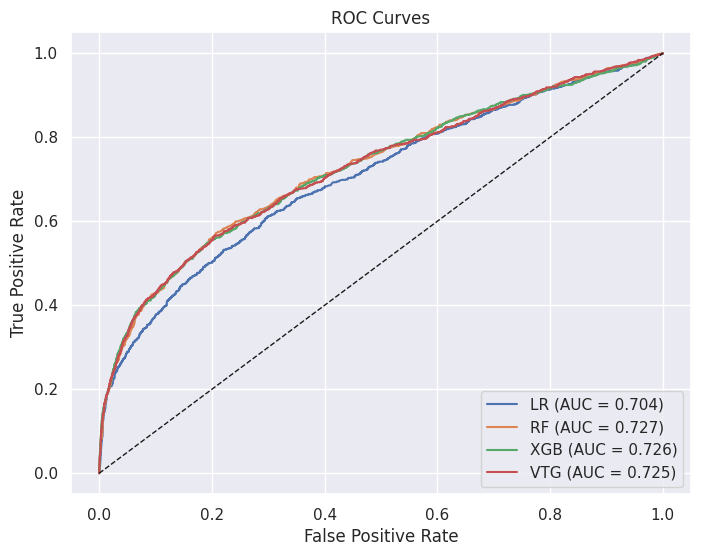

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(8, 6))
    for name, model in models:
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

# Usage
models = [('LR', lr_pipeline), ('RF', rf_no_smote), ('XGB', xg_boost_nosmote), ('VTG', voting_clf)]
plot_roc_curves(models, X_test,y_test_transformed)

**Findings**: These models, with the exception of logistic regression are very high performing and can be used in production with the estimated precision or recall scores. However it may be easier to ship Random Forest model because of its speed and realiability.

# 11. Conclusion

Based on the model evaluations and feature analysis, here are some potential business interpretations and actionable insights:

*   **Key Drivers of Subscription:**
    *   poutcome_success: People who have responded favorably to previous campaigns are more likely to say yes this time.
    *   Clients without housing loans appear more likely to subscribe.
    *   Those that have more balance with respect to their age are more likely to open accounts.


*   **Model Usage:**  The trained models can be used for:
    *   Scoring potential clients based on their likelihood of subscribing to prioritize outreach efforts towards those with the highest probability.

*   **Next Steps:** This model is used for when the campaign has not started, and therefore we haven't made use of campaign variable. In the next step we can develop a model that uses that feature too, so that dynamically we can optimize whom to call.



In this notebook, we went through the process of building a machine learning model to predict bank term deposit subscriptions. We started with data loading and exploratory data analysis to understand the data and identify key patterns and relationships. We then performed data cleaning and preprocessing steps, including handling missing values, standardizing numerical features, and encoding categorical variables. We engineered a new feature to handle the special case of the 'pdays' variable.

We trained and evaluated three different classification models: Logistic Regression, Random Forest, and Gradient Boosting. We compared their performance using various metrics, including ROC AUC, Precision, Recall, and F1-score.

Finally, we discussed the business interpretation of the model's findings, outlining actionable insights and potential uses for the model in targeted marketing campaigns. We also discussed potential next steps for improving the model and important considerations for deployment, including limitations, assumptions, and biases.

This analysis provides a solid foundation for understanding the factors influencing term deposit subscriptions and a predictive model that can be used to optimize future marketing efforts.